# ZFX

In [3]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


### ZFX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZFX.

In [1]:
gene_symbol = 'ZFX'
mane_tx_id = 'NM_003410.4'
mane_protein_id = 'NP_003401.2' # zinc finger X-chromosomal protein isoform 1 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 18 phenopackets
Individuals Processed: 100%|██████████| 18/18 [00:24<00:00,  1.36s/individuals]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Delayed fine motor development,HP:0010862,16
Delayed speech and language development,HP:0000750,16
Delayed ability to walk,HP:0031936,15
Hypotonia,HP:0001252,13
Inguinal hernia,HP:0000023,13
Thin upper lip vermilion,HP:0000219,12
Caesarian section,HP:0011410,9
Umbilical hernia,HP:0001537,9
Macroglossia,HP:0000158,9
Autism,HP:0000717,9


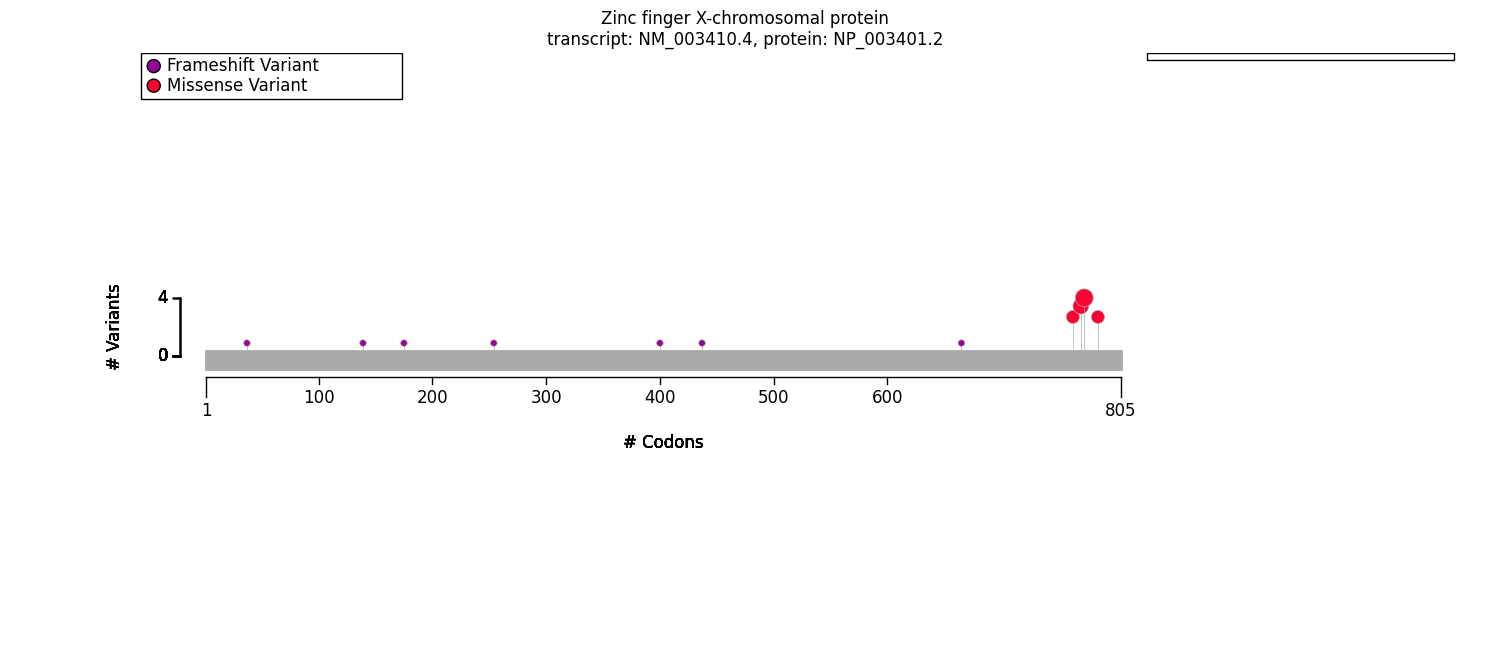

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [7]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.model import FeatureType
from gpsea.analysis.predicate import PatientCategories
from gpsea.view import MtcStatsViewer
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.mtc_filter import UseAllTermsMtcFilter
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.pcats import HpoTermAnalysis


pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)

mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.1)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

count_statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)


In [8]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.model import VariantEffect


is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_missense,
)

gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [9]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.1,61
HMF02,Skipping term because no genotype has more than one observed HPO count,62
HMF04,Skipping term because all genotypes have same HPO observed proportions,62
HMF06,Skipping term with less than 7 observations (not powered for 2x2),134
HMF08,Skipping general term,82


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         HOM_REF            HET  \
                                                     Count Percent  Count   
Umbilical hernia [HP:0001537]                          1/7     14%   8/11   
Ventricular septal defect [HP:0001629]                 2/5     40%    0/9   
Astigmatism [HP:0000483]                               0/7      0%   4/11   
Thick eyebrow [HP:0000574]                             0/7      0%   4/11   
Obstructive sleep apnea [HP:0002870]                   0/7      0%   4/11   
Midface retrusion [HP:0011800]                         2/7     29%   0/11   
Enlarged naris [HP:0009931]                            2/7     29%   0/11   
Thin upper lip vermilion [HP:0000219]                  3/7     43%   9/11   
Smooth philtrum [HP:0000319]                           4/7     57%   2/11   
Pointed chin [HP:0000307]                              1/7     14%   6/11   
Long philtrum [HP:0000343]                             1/7     14%   6/11   
Hydronephrosis [HP:0000126]                            2/7     29%   0/10   
Intellectual disability, mild [HP:0001256]             0/4      0%   5/10   
Anger [HP:0031473]                                     0/7      0%   3/11   
Wide mouth [HP:0000154]                                0/7      0%   3/11   
Supernumerary tooth [HP:0011069]                       0/7      0%   3/11   
Bulbous nose [HP:0000414]                              0/7      0%   3/11   
Hypospadias [HP:0000047]                               2/6     33%    6/8   
Cryptorchidism [HP:0000028]                            1/6     17%    4/8   
Sensorineural hearing impairment [HP:0000407]          1/7     14%   5/11   
Attention deficit hyperactivity disorder [HP:00...     1/7     14%   5/11   
Synophrys [HP:0000664]                                 1/7     14%   5/11   
Hypotonia [HP:0001252]                                 4/7     57%   9/11   
Inguinal hernia [HP:0000023]                           4/7     57%   9/11   
Macroglossia [HP:0000158]                              2/7     29%   7/11   
Choroid plexus cyst [HP:0002190]                       0/6      0%    2/7   
Hyperparathyroidism [HP:0000843]                       0/5      0%    2/7   
Delayed fine motor development [HP:0010862]            7/7    100%   9/11   
Downslanted palpebral fissures [HP:0000494]            0/7      0%   2/11   
Fine hair [HP:0002213]                                 0/7      0%   2/11   
Cleft palate [HP:0000175]                              0/7      0%   2/11   
Vomiting [HP:0002013]                                  0/7      0%   2/11   
Anxiety [HP:0000739]                                   0/7      0%   2/11   
Single transverse palmar crease [HP:0000954]           0/7      0%   2/11   
Thickened helices [HP:0000391]                         0/7      0%   2/11   
Polyhydramnios [HP:0001561]                            0/7      0%   2/11   
Broad forehead [HP:0000337]                            2/7     29%   1/11   
Long palpebral fissure [HP:0000637]                    2/7     29%   1/11   
Conductive hearing impairment [HP:0000405]             1/7     14%   4/11   
Premature birth [HP:0001622]                           3/7     43%   3/11   
Epicanthus [HP:0000286]                                3/7     43%   3/11   
Broad eyebrow [HP:0011229]                             4/7     57%   4/11   
Caesarian section [HP:0011410]                         4/7     57%   5/11   
Delayed ability to walk [HP:0031936]                   6/7     86%   9/11   
Delayed speech and language development [HP:000...     6/7     86%  10/11   
Constipation [HP:0002019]                              1/5     20%   3/11   
Intellectual disability, moderate [HP:0002342]         1/4     25%   2/10   
Long face [HP:0000276]                                 2/7     29%   2/11   
High palate [HP:0000218]                               1/7     14%   2/11   
Posteriorly rotated ears [HP:0000358]                  1/7     14%   2/11

# Summary
no evidence for GPC. TODO repeat with final API.